In [33]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv1D, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K
import time
import numpy as np

In [34]:
# 損失函數
def l2_loss(y_true, y_pred):
    diff = y_true - y_pred
    #print(f"Difference (diff): {diff.numpy()}")
    #print(f"y_true (label): {y_true}")
    #print(f"y_pred (label_pred): {y_pred}")
    loss = tf.reduce_mean(tf.square(diff))
    #print(f"loss: {loss}")
    return loss

In [4]:
model = load_model('CNN_TL_addDropout.h5')

In [5]:
# 加上全連接層
x = model.output

predictions = Dense(12, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                           

In [37]:
# 載入資料集
def load_gesture_data(directory):
    gesture_data = []
    labels = []
    
    categories = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            categories.append(category)
    
    category_files = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        files = []
        for file in os.listdir(category_path):
            if file.endswith('.npy'):
                files.append(file)
        category_files[category] = files
    
    max_files = 0
    for files in category_files.values():
        if len(files) > max_files:
            max_files = len(files)
    
    for i in range(max_files):
        for category in categories:
            files = category_files[category]
            
            if i < len(files):
                file_name = files[i]
                file_path = os.path.join(category, file_name)
                file_path_full = os.path.join(directory, file_path)
                print(f"Loading {file_path_full}")
                data = np.load(file_path_full)
                gesture_data.append(data)
                labels.append(category)  
    
    return np.array(gesture_data), labels


In [5]:
# Load gesture data
gesture_data_train, gesture_labels_train = load_gesture_data('traindata_general\\train')
gesture_data_test, gesture_labels_test = load_gesture_data('traindata_general\\test')
gesture_data_val, gesture_labels_val = load_gesture_data('traindata_general/validation')

print("Original Gesture data train shape:", np.shape(gesture_data_train))
print("Original Gesture labels train shape:", np.shape(gesture_labels_train))

# Reshape gesture data
x_train_gesture = np.reshape(gesture_data_train, (-1, 2, 32, 32, 35))
x_test_gesture = np.reshape(gesture_data_test, (-1, 2, 32, 32, 35))
x_val_gesture = np.reshape(gesture_data_val, (-1, 2, 32, 32, 35))

x_train_gesture = np.transpose(x_train_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_test_gesture = np.transpose(x_test_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_val_gesture = np.transpose(x_val_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)

# Repeat labels to match data shape
gesture_labels_train = np.repeat(gesture_labels_train, 35)
gesture_labels_test = np.repeat(gesture_labels_test, 35)
gesture_labels_val = np.repeat(gesture_labels_val, 35)

# Encode and one-hot encode gesture labels
label_encoder = LabelEncoder()
gesture_labels_train_encoded = label_encoder.fit_transform(gesture_labels_train)
gesture_labels_test_encoded = label_encoder.transform(gesture_labels_test)
gesture_labels_val_encoded = label_encoder.transform(gesture_labels_val)

gesture_labels_train_one_hot = to_categorical(gesture_labels_train_encoded, num_classes=12)
gesture_labels_test_one_hot = to_categorical(gesture_labels_test_encoded, num_classes=12)
gesture_labels_val_one_hot = to_categorical(gesture_labels_val_encoded, num_classes=12)

gesture_labels_train_one_hot = np.reshape(gesture_labels_train_one_hot, (-1, 1, 12))
gesture_labels_test_one_hot = np.reshape(gesture_labels_test_one_hot, (-1, 1, 12))
gesture_labels_val_one_hot = np.reshape(gesture_labels_val_one_hot, (-1, 1, 12))

print("Reshaped Gesture data train shape:", x_train_gesture.shape)
print("Reshaped Gesture labels train shape:", gesture_labels_train_one_hot.shape)

Loading traindata_general\train\BG_Static\ST_falldown_0.npy
Loading traindata_general\train\falldown\falldown_segment_10193.npy
Loading traindata_general\train\nono\nono_segment_10224.npy
Loading traindata_general\train\patpat\patpat_segment_10261.npy
Loading traindata_general\train\slowUp\slowUp_segment_10300.npy
Loading traindata_general\train\swipeDown\swipeDown_segment_10000.npy
Loading traindata_general\train\swipeLeft\swipeLeft_segment_10015.npy
Loading traindata_general\train\swipeRight\swipeRight_segment_10053.npy
Loading traindata_general\train\swipeUp\swipeUp_segment_10090.npy
Loading traindata_general\train\BG_Static\ST_falldown_1.npy
Loading traindata_general\train\falldown\falldown_segment_10194.npy
Loading traindata_general\train\nono\nono_segment_10225.npy
Loading traindata_general\train\patpat\patpat_segment_10262.npy
Loading traindata_general\train\slowUp\slowUp_segment_10301.npy
Loading traindata_general\train\swipeDown\swipeDown_segment_10001.npy
Loading traindata_ge

In [6]:
# 使用CDF動態採樣背景訓練集
def load_and_select_data(num_selections, num_bg_classes=3, num_gesture_classes=9, validation_split=0.1):
    path1 = "dataset\\BackGround_MV_809\\data_Background_0001_2024_08_22_12_08_35.h5.npy"
    data1 = np.load(path1)

    path2 = "dataset\\BackGround_MV_809_pat\\data_Background_0001_2024_08_22_12_17_23.h5.npy"
    data2 = np.load(path2)

    path3 = "dataset\\BackGround_falldown\\data_Background_0001_2024_08_22_15_50_59.h5.npy"
    data3 = np.load(path3)

    total_elements_data1 = data1.shape[-1]
    total_elements_data2 = data2.shape[-1]
    total_elements_data3 = data3.shape[-1]

    weight1 = 1.0
    weight2 = 10.0
    weight3 = 17.0

    weights = [weight1] * total_elements_data1 + [weight2] * total_elements_data2 + [weight3] * total_elements_data3
    total_weight = np.sum(weights)
    probabilities = np.array(weights) / total_weight

    cdf = np.cumsum(probabilities)
    uniform_random_numbers = np.random.uniform(0, cdf[-1], size=num_selections)
    selected_indices = np.searchsorted(cdf, uniform_random_numbers)

    selected_data = []
    selected_labels = []

    bg_labels_12 = np.zeros((num_bg_classes, 12))
    bg_labels_12[np.arange(num_bg_classes), np.arange(num_bg_classes) + 9] = 1

    for index in selected_indices:
        if index < total_elements_data1:
            selected_data.append(data1[..., index])
            selected_labels.append(bg_labels_12[index % num_bg_classes])
        elif index < total_elements_data1 + total_elements_data2:
            index2 = index - total_elements_data1
            selected_data.append(data2[..., index2])
            selected_labels.append(bg_labels_12[index2 % num_bg_classes])
        else:
            index3 = index - (total_elements_data1 + total_elements_data2)
            selected_data.append(data3[..., index3])
            selected_labels.append(bg_labels_12[index3 % num_bg_classes])

    selected_data = np.array(selected_data)
    selected_data = np.reshape(selected_data, (num_selections, 2, 32, 32, 1))
    selected_data = np.transpose(selected_data, (0, 2, 3, 4, 1))
    selected_data = np.reshape(selected_data, (num_selections, 32, 32, 2))

    selected_labels = np.array(selected_labels).reshape(-1, 1, 12)

    num_val = int(num_selections * validation_split)
    num_train = num_selections - num_val

    x_train = selected_data[:num_train]
    y_train = selected_labels[:num_train]
    x_val = selected_data[num_train:]
    y_val = selected_labels[num_train:]
    return (x_train, y_train), (x_val, y_val)


In [7]:
def AGIprogressBar(count, total,start):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    duration=time.time()-start
    print('\r[%s] %s%s ...%s sec' % (bar, percents, '%', duration),end=' ')

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=l2_loss, metrics=['accuracy'])

In [12]:
Batch = 6720
epochs = 5000

rec = []
st = time.time()

for ep in range(epochs):
    (num_train_selections, num_bg_classes, num_gesture_classes) = (150000, 3, 9)
    ((x_train, y_train), (x_val, y_val)) = load_and_select_data(num_selections=num_train_selections, num_bg_classes=num_bg_classes, num_gesture_classes=num_gesture_classes)
    x_train_combined = np.concatenate((x_train_gesture, x_train), axis=0)
    y_train_combined = np.concatenate((gesture_labels_train_one_hot, y_train), axis=0)

    print(f'EP: {ep + 1}')
    
    for i in range(len(x_train_combined) // Batch):
        rand = np.random.randint(0, len(x_train_combined), size=Batch)
        AGIprogressBar(i, len(x_train_combined) // Batch, st)

        x_batch = np.array([x_train_combined[idx] for idx in rand])
        y_batch = np.array([y_train_combined[idx] for idx in rand])

        resultSt = model.train_on_batch(x_batch, y_batch)

    pre = model.predict(x_val, verbose=0)
    acc = np.sum(np.argmax(pre, axis=2) == np.argmax(np.array(y_val), axis=2)) / len(y_val)
    rec.append(acc)
    print(f'ACC = {acc}')

    if (ep + 1) % 10 == 0:
        model.save(f'saved_model_stage1_CNN/CNN_epoch_{ep + 1}_stage1.h5')
        print(f'Model saved at epoch {ep + 1}')


EP: 1
[===========================================================-] 99.0% ...19.284603357315063 sec ACC = 0.08773333333333333
EP: 2
[===========================================================-] 99.0% ...39.079153537750244 sec ACC = 0.13433333333333333
EP: 3
[===========================================================-] 99.0% ...58.936564207077026 sec ACC = 0.20673333333333332
EP: 4
[===========================================================-] 99.0% ...78.16062331199646 sec ACC = 0.33086666666666664
EP: 5
[===========================================================-] 99.0% ...96.78298544883728 sec ACC = 0.3252
EP: 6
[===========================================================-] 99.0% ...115.43655753135681 sec ACC = 0.31693333333333334
EP: 7
[===========================================================-] 99.0% ...134.2964563369751 sec  ACC = 0.3078
EP: 8
[===========================================================-] 99.0% ...153.1467785835266 sec  ACC = 0.3066
EP: 9
[==================

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/online_cnn_fw/depthwise_conv2d_10/depthwise1/depthwise/DepthwiseConv2dNativeBackpropInput' defined at (most recent call last):
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\joe84\AppData\Local\Temp\ipykernel_10988\3717518181.py", line 26, in <module>
      resultSt = model.train_on_batch(x_batch, y_batch)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\engine\training.py", line 2381, in train_on_batch
      logs = self.train_function(iterator)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\joe84\anaconda3\envs\KKT\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/online_cnn_fw/depthwise_conv2d_10/depthwise1/depthwise/DepthwiseConv2dNativeBackpropInput'
OOM when allocating tensor with shape[6720,15,15,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/online_cnn_fw/depthwise_conv2d_10/depthwise1/depthwise/DepthwiseConv2dNativeBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1193]

In [7]:
# 以下程式碼用來Predict CNN 以取得LSTM訓練集
model = load_model('saved_model_stage1_CNN_1\CNN_epoch_760_stage1.h5', custom_objects={'l2_loss':l2_loss})

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        20        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       96        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         320       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                             

In [40]:
# hook BN Layer
hook=[]
id=[10]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [41]:
ModelExtract.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'batch_normalization')>

In [46]:
predictions = ModelExtract.predict(x_test_gesture)
labels = gesture_labels_test_one_hot

1999/1999 [==============================] - 4s 2ms/step


In [47]:
# 根據需求保存預測結果
np.save('Stage_Bath_LSTM/predictions_test.npy', predictions)
np.save('Stage_Bath_LSTM/predictions_labels_test', labels)

In [12]:
path1 = "dataset\\BackGround_MV_809\\data_Background_0001_2024_08_22_12_08_35.h5.npy"
data1 = np.load(path1)

path2 = "dataset\\BackGround_MV_809_pat\\data_Background_0001_2024_08_22_12_17_23.h5.npy"
data2 = np.load(path2)

path3 = "dataset\\BackGround_falldown\\data_Background_0001_2024_08_22_15_50_59.h5.npy"
data3 = np.load(path3)

In [52]:
data1 = np.transpose(data1, [3, 1, 2, 0])

In [53]:
predictions = ModelExtract.predict(data1)

67/67 [==============================] - 0s 2ms/step


In [21]:
np.save('LSTM\LSTM_STAGE1/BackGround_falldown.npy', predictions)

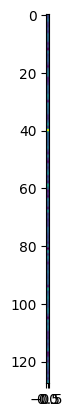

In [49]:
tfdata = predictions
tfdataN=255*(tfdata-np.min(tfdata)/np.max(tfdata))
plt.imshow(tfdataN[0].reshape(-1, 1))

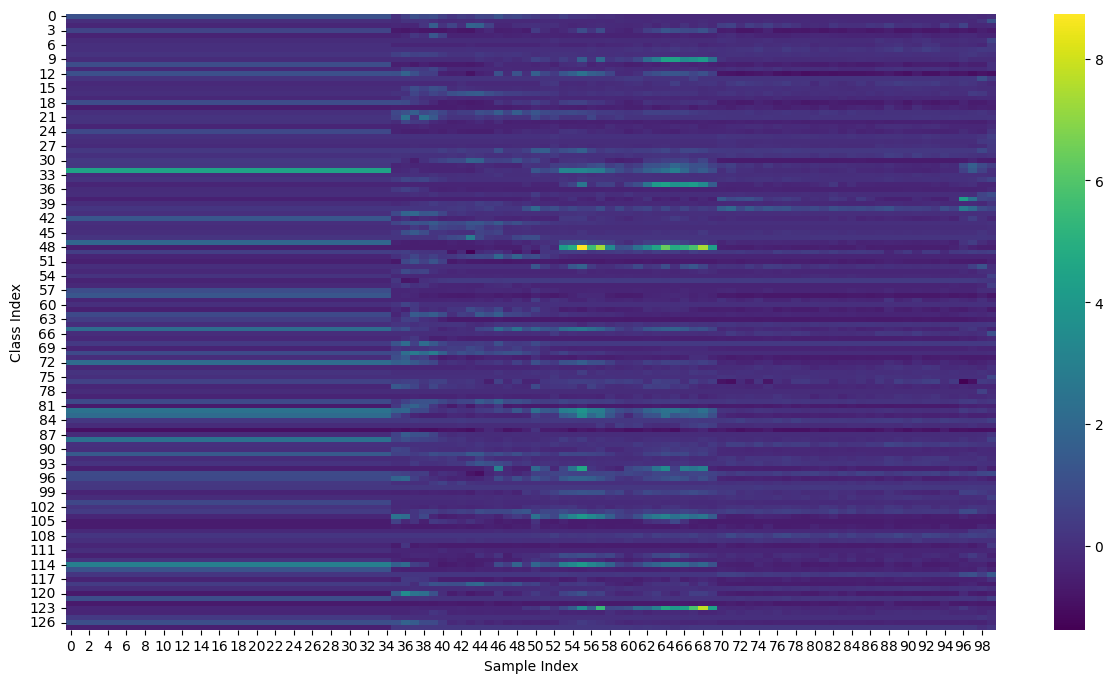

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(predictions[:100].T, cmap="viridis", cbar=True)
plt.xlabel('Sample Index')
plt.ylabel('Class Index')
plt.show()


In [18]:
# 合併手勢資料和背景資料
x_test = np.load('BG_test_bath.npy')
y_test = np.load('BG_test_label_bath.npy')
y_test = np.squeeze(y_test, axis=1)
x_test_combined = np.concatenate((x_test_gesture, x_test), axis=0)
y_test_combined = np.concatenate((gesture_labels_test_one_hot, y_test), axis=0)   

In [19]:
# 洗牌測試集
indices = np.random.permutation(len(x_test_combined))

x_test_combined_shuffled = x_test_combined[indices]
y_test_combined_shuffled = y_test_combined[indices]

In [79]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                             

In [23]:
# 神經元分析
# hook其中幾層 CNN
hook=[]
id=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [24]:
predictions = ModelExtract.predict(x_test_combined_shuffled)
labels = y_test_combined_shuffled

2468/2468 [==============================] - 9s 4ms/step


In [28]:
labels = np.argmax(y_test_combined_shuffled, axis=1)

In [21]:
np.save('predictions_test_bath.npy', predictions)
np.save('labels_bath.npy', labels)

In [94]:
model = load_model('CNN_epoch_2500_stage1.h5', custom_objects={'l2_loss':l2_loss})

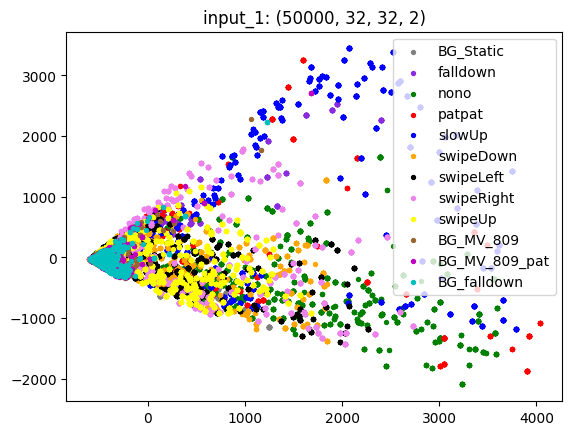

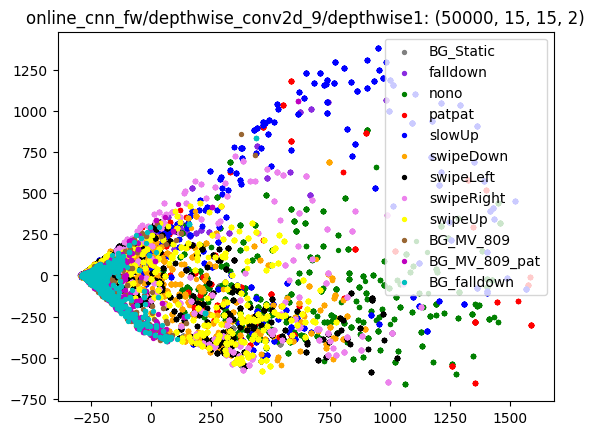

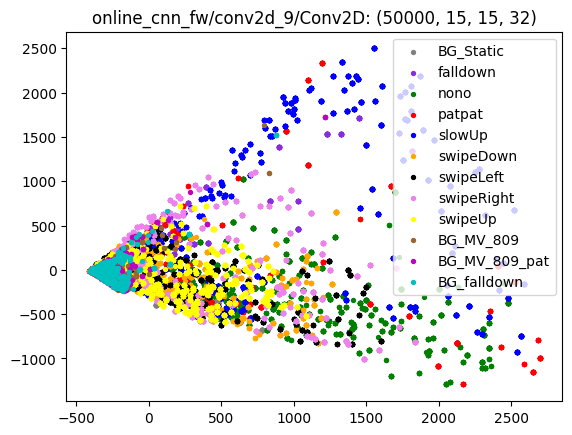

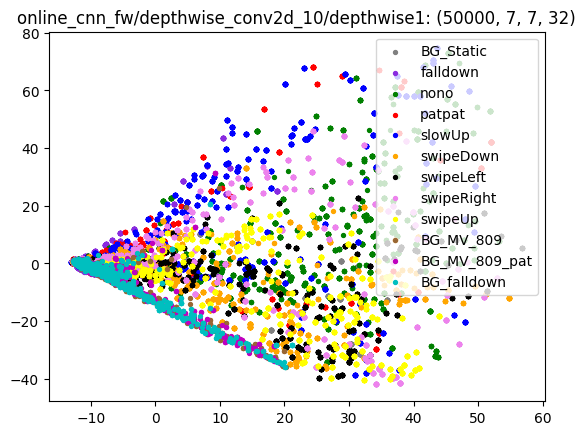

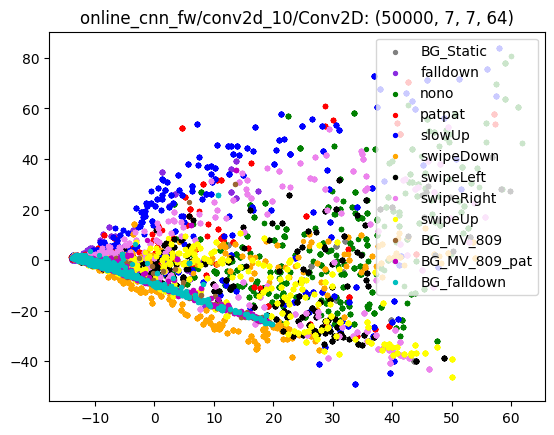

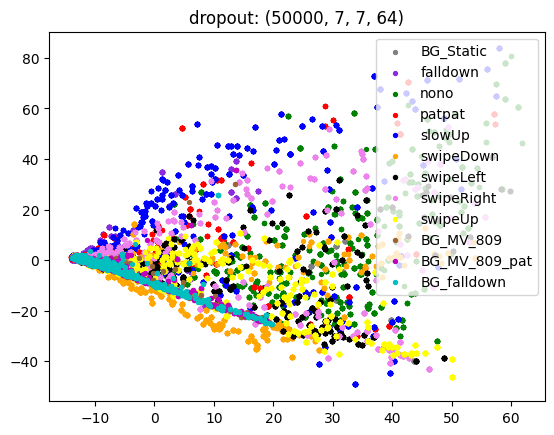

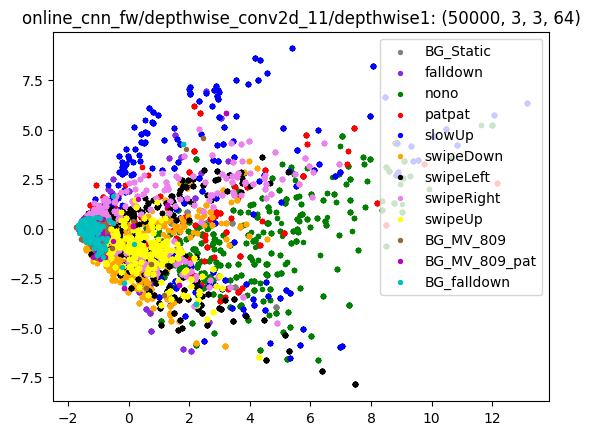

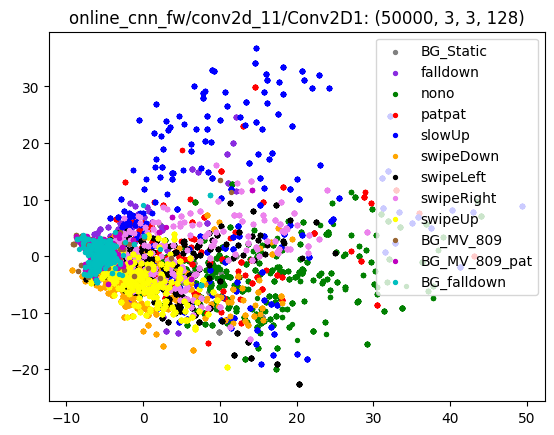

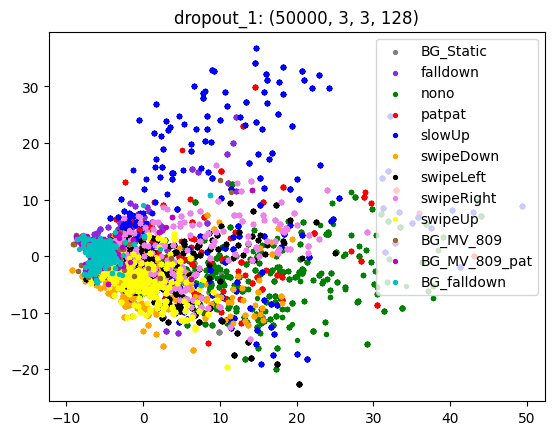

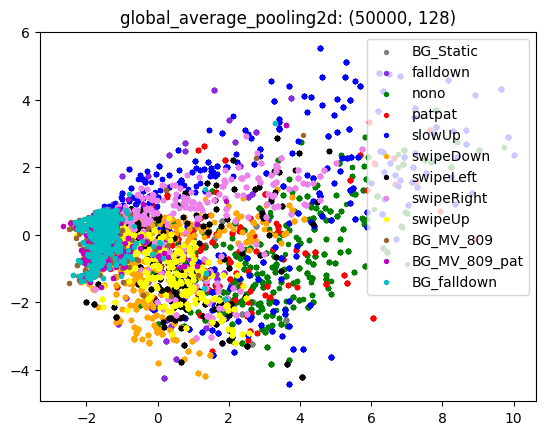

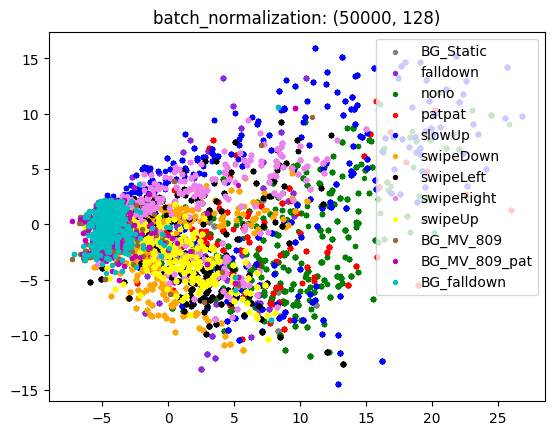

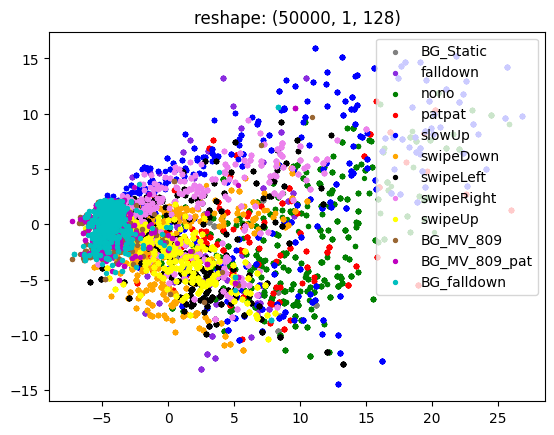

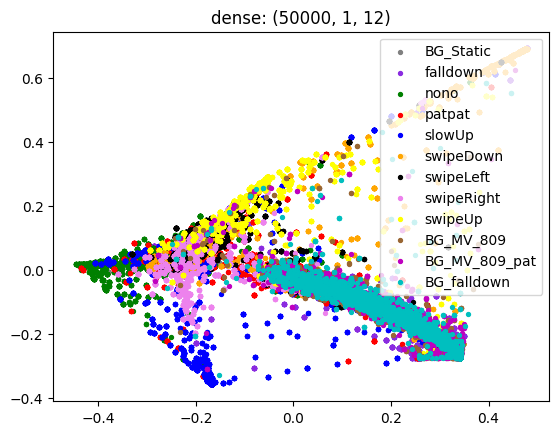

In [97]:
# PCA 
from sklearn import decomposition
PCA=[]

classes = ['BG_Static', 'falldown', 'nono', 'patpat', 'slowUp', 'swipeDown', 'swipeLeft', 'swipeRight', 'swipeUp', 'BG_MV_809', 'BG_MV_809_pat', 'BG_falldown']

label_to_color = {
    'patpat': [1, 0, 0, 1], # Red
    'nono': [0, 0.5, 0, 1], # Green
    'slowUp': [0, 0, 1, 1], # Blue
    'swipeDown': [1, 0.65, 0, 1], # Orange
    'swipeUp': [1, 1, 0, 1], # Yellow
    'swipeLeft': [0, 0, 0, 1], # Black
    'swipeRight': [0.93, 0.51, 0.93, 1], # Violet
    'falldown': [0.54, 0.17, 0.88, 1], # Purple
    'background_moving': [0, 1, 1, 1], # Cyan
    'BG_Static': [0.5, 0.5, 0.5, 1], # Gray
    'BG_MV_809': [0.6, 0.4, 0.2, 1], # Brown
    'BG_MV_809_pat': [0.75, 0, 0.75, 1], # Magenta
    'BG_falldown': [0, 0.75, 0.75, 1] # Teal
}

for i in range(len(predictions)):
    input=np.reshape(predictions[i],[len(predictions[i]),-1])
    pca=decomposition.PCA(n_components=2)
    pca.fit(input)
    PCA.append(pca)
    Dim2=PCA[-1].transform(input)
    plt.figure()
    plt.title(model.layers[id[i]].name+': '+f'{predictions[i].shape}')
    for cl in range(12):
        chos=Dim2[np.argwhere(labels==cl).reshape([-1])]
        color = label_to_color[classes[cl]]
        plt.scatter(chos[:, 0], chos[:, 1], label=classes[cl], marker='o', s=8, color=color)
    plt.legend(loc=1)

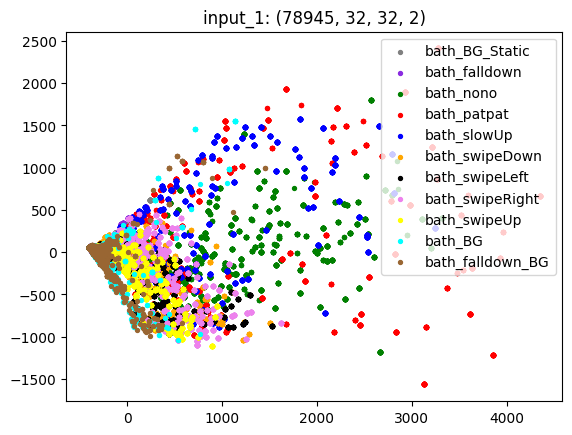

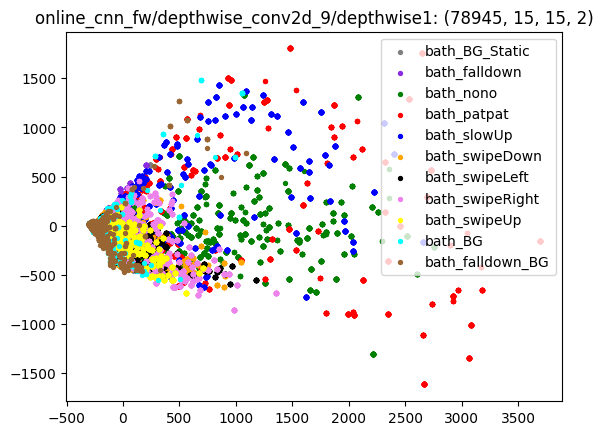

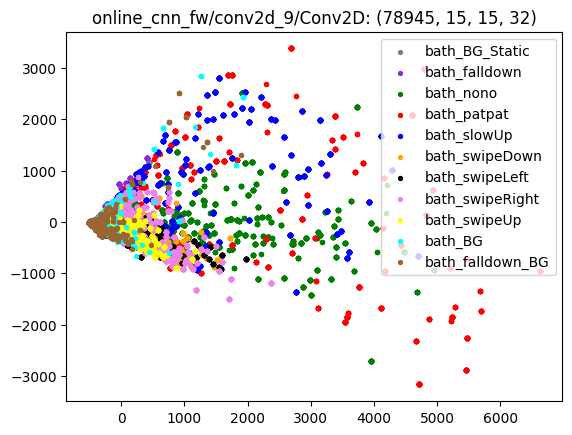

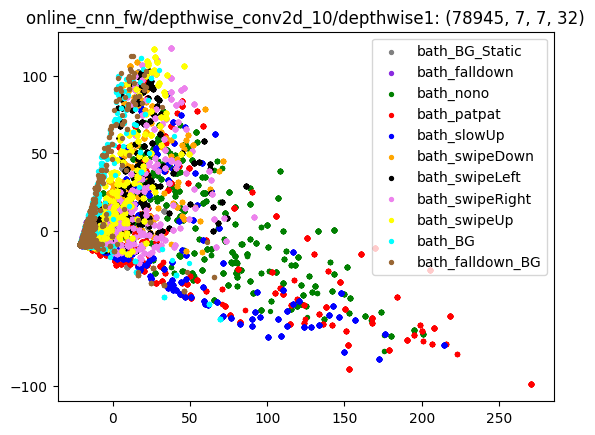

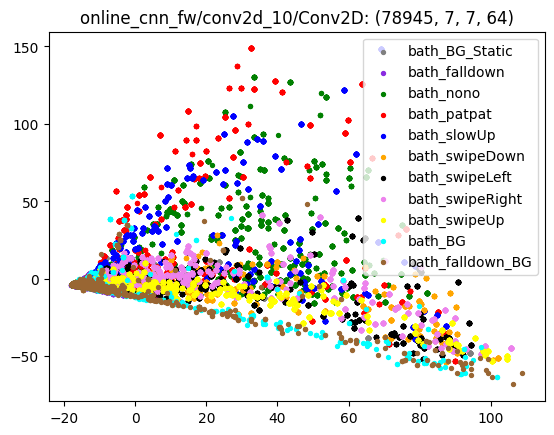

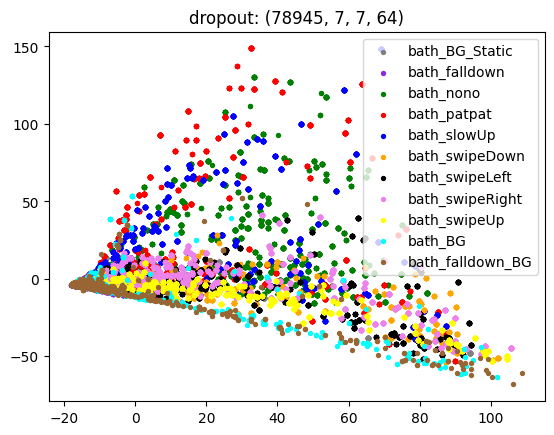

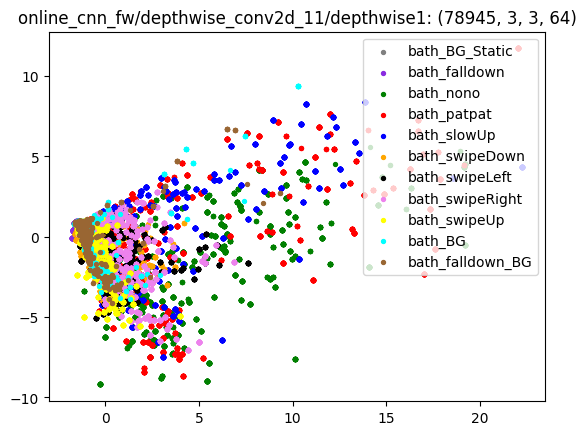

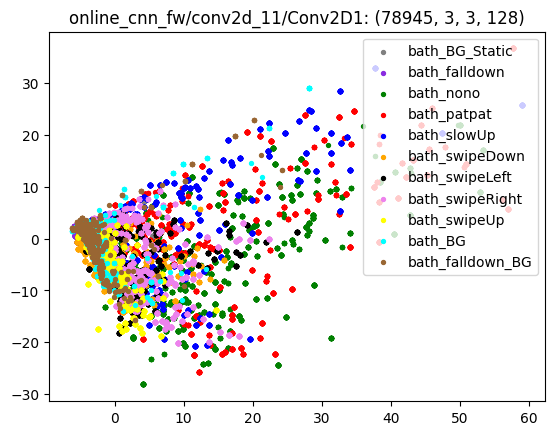

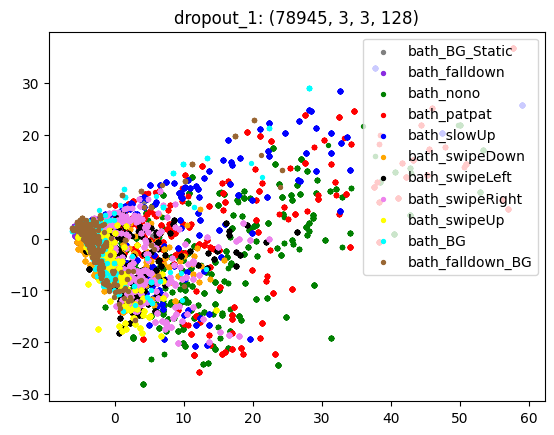

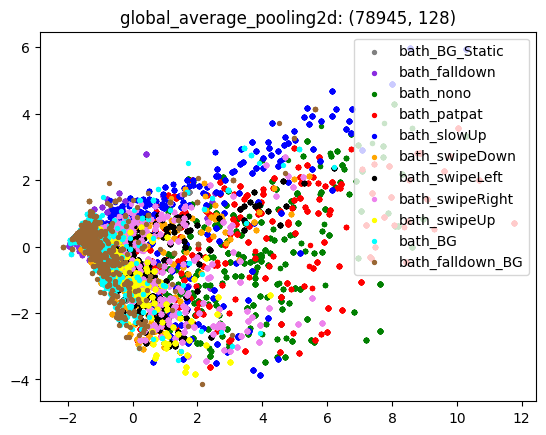

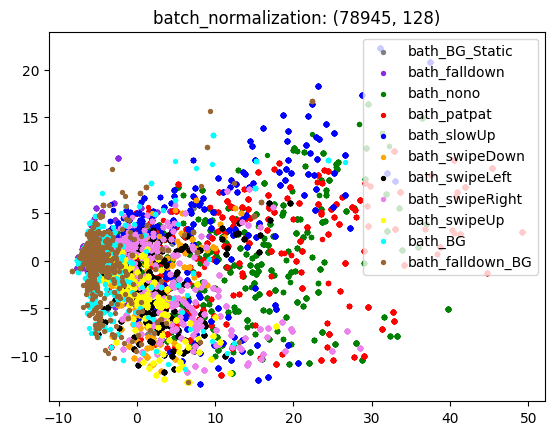

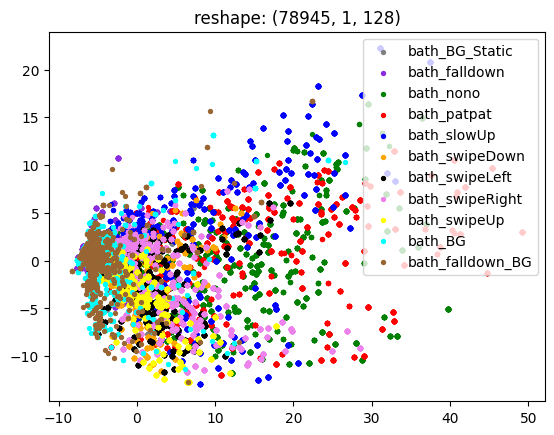

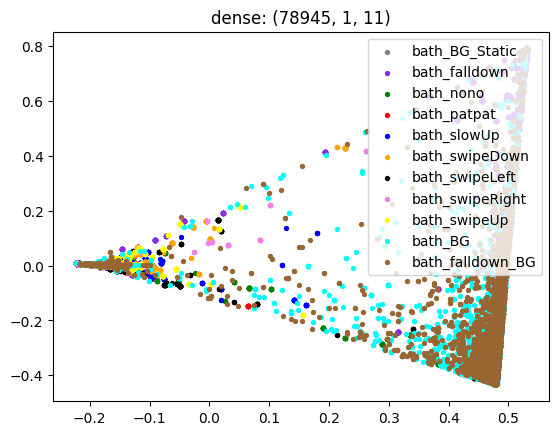

In [29]:
# PCA 
from sklearn import decomposition
PCA=[]

classes = ['bath_BG_Static', 'bath_falldown', 'bath_nono', 'bath_patpat', 'bath_slowUp', 'bath_swipeDown', 'bath_swipeLeft', 'bath_swipeRight', 'bath_swipeUp', 'bath_BG', 'bath_falldown_BG']

label_to_color = {
    'bath_patpat': [1, 0, 0, 1], # Red
    'bath_nono': [0, 0.5, 0, 1], # Green
    'bath_slowUp': [0, 0, 1, 1], # Blue
    'bath_swipeDown': [1, 0.65, 0, 1], # Orange
    'bath_swipeUp': [1, 1, 0, 1], # Yellow
    'bath_swipeLeft': [0, 0, 0, 1], # Black
    'bath_swipeRight': [0.93, 0.51, 0.93, 1], # Violet
    'bath_falldown': [0.54, 0.17, 0.88, 1], # Purple
    'bath_BG': [0, 1, 1, 1], # Cyan
    'bath_BG_Static': [0.5, 0.5, 0.5, 1], # Gray
    'bath_falldown_BG': [0.6, 0.4, 0.2, 1], # Brown
}

for i in range(len(predictions)):
    input=np.reshape(predictions[i],[len(predictions[i]),-1])
    pca=decomposition.PCA(n_components=2)
    pca.fit(input)
    PCA.append(pca)
    Dim2=PCA[-1].transform(input)
    plt.figure()
    plt.title(model.layers[id[i]].name+': '+f'{predictions[i].shape}')
    for cl in range(11):
        chos=Dim2[np.argwhere(labels==cl).reshape([-1])]
        color = label_to_color[classes[cl]]
        plt.scatter(chos[:, 0], chos[:, 1], label=classes[cl], marker='o', s=8, color=color)
    plt.legend(loc=1)